<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading 

**Chapter 08 &mdash; CFD Trading with Oanda**

## The Oanda API

`pip install git+https://github.com/yhilpisch/tpqoa.git`

In [1]:
import tpqoa

In [2]:
api = tpqoa.tpqoa('../pyalgo.cfg')

## Retrieving Historical Data

### Looking Up Instruments Available for Trading

In [3]:
api.get_instruments()[:15]

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD'),
 ('AUD/SGD', 'AUD_SGD'),
 ('AUD/USD', 'AUD_USD'),
 ('Australia 200', 'AU200_AUD'),
 ('Brent Crude Oil', 'BCO_USD'),
 ('Bund', 'DE10YB_EUR'),
 ('CAD/CHF', 'CAD_CHF'),
 ('CAD/HKD', 'CAD_HKD'),
 ('CAD/JPY', 'CAD_JPY'),
 ('CAD/SGD', 'CAD_SGD'),
 ('CHF/HKD', 'CHF_HKD')]

### Backtesting a Momentum Strategy on Minute Bars

In [4]:
help(api.get_history)

Help on method get_history in module tpqoa.tpqoa:

get_history(instrument, start, end, granularity, price, localize=True) method of tpqoa.tpqoa.tpqoa instance
    Retrieves historical data for instrument.
    
    Parameters
    instrument: string
        valid instrument name
    start, end: datetime, str
        Python datetime or string objects for start and end
    granularity: string
        a string like 'S5', 'M1' or 'D'
    price: string
        one of 'A' (ask), 'B' (bid) or 'M' (middle)
    
    Returns
    data: pd.DataFrame
        pandas DataFrame object with data



In [5]:
instrument = 'EUR_USD'
start = '2020-05-27'
end = '2020-05-29'
granularity = 'M1'
price = 'M'

In [6]:
data = api.get_history(instrument, start, end,
                      granularity, price)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2822 entries, 2020-05-27 00:00:00 to 2020-05-28 23:59:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         2822 non-null   float64
 1   h         2822 non-null   float64
 2   l         2822 non-null   float64
 3   c         2822 non-null   float64
 4   volume    2822 non-null   int64  
 5   complete  2822 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 135.0 KB


In [8]:
data[['c', 'volume']].head()

,c,volume
time,,
2020-05-27 00:00:00,1.09788,34
2020-05-27 00:01:00,1.09776,31
2020-05-27 00:02:00,1.09763,27
2020-05-27 00:03:00,1.09764,25
2020-05-27 00:04:00,1.09768,20


In [9]:
import numpy as np

In [10]:
data['returns'] = np.log(data['c'] / data['c'].shift(1))

In [11]:
cols = []

In [12]:
for momentum in [15, 30, 60, 120]:
    col = 'position_{}'.format(momentum)
    data[col] = np.sign(data['returns'].rolling(momentum).mean())
    cols.append(col)

In [13]:
from pylab import plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

In [14]:
strats = ['returns']

In [15]:
for col in cols:
    strat = 'strategy_{}'.format(col.split('_')[1])
    data[strat] = data[col].shift(1) * data['returns']
    strats.append(strat)

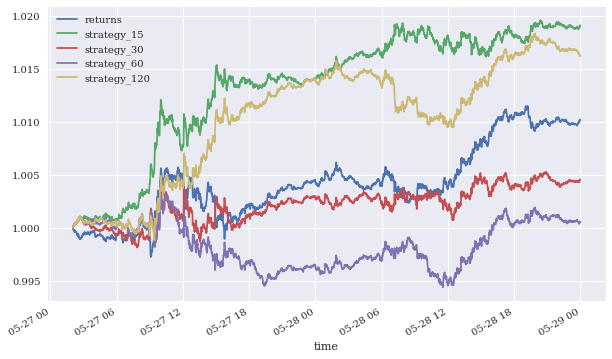

In [16]:
data[strats].dropna().cumsum(
    ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch08/oanda_plot_1.png')

### Factoring In Leverage and Margin

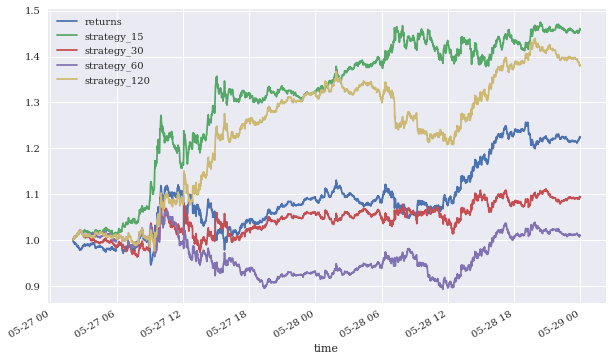

In [17]:
data[strats].dropna().cumsum().apply(
            lambda x: x * 20).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch08/oanda_plot_2.png');

## Working with Streaming Data

In [18]:
instrument = 'EUR_USD'

In [19]:
api.stream_data(instrument, stop=10)

2020-06-01T12:09:53.948885097Z 1.11147 1.11159
2020-06-01T12:09:58.590777185Z 1.11149 1.11162
2020-06-01T12:09:58.673870044Z 1.1115 1.11164
2020-06-01T12:09:59.202511358Z 1.11152 1.11165
2020-06-01T12:09:59.730651854Z 1.11151 1.11164
2020-06-01T12:09:59.970253663Z 1.1115 1.11163
2020-06-01T12:10:07.050565764Z 1.11148 1.11162
2020-06-01T12:10:18.148637040Z 1.11151 1.11164
2020-06-01T12:10:18.459492370Z 1.11152 1.11165
2020-06-01T12:10:20.439281118Z 1.11153 1.11167


## Placing Orders

In [20]:
help(api.create_order)

Help on method create_order in module tpqoa.tpqoa:

create_order(instrument, units, price=None, sl_distance=None, tsl_distance=None, tp_price=None, comment=None, touch=False, suppress=False, ret=False) method of tpqoa.tpqoa.tpqoa instance
    Places order with Oanda.
    
    Parameters
    instrument: string
        valid instrument name
    units: int
        number of units of instrument to be bought
        (positive int, eg 'units=50')
        or to be sold (negative int, eg 'units=-100')
    price: float
        limit order price, touch order price
    sl_distance: float
        stop loss distance price, mandatory eg in Germany
    tsl_distance: float
        trailing stop loss distance
    tp_price: float
        take profit price to be used for the trade
    comment: str
        string
    touch: boolean
        market_if_touched order (requires price to be set)
    suppress: boolean
        whether to suppress print out
    ret: boolean
        whether to return the order obje

In [21]:
api.create_order(instrument, 1000)



 {'id': '903', 'time': '2020-06-01T12:10:20.832960817Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '902', 'requestID': '60716389480704559', 'type': 'ORDER_FILL', 'orderID': '902', 'instrument': 'EUR_USD', 'units': '1000.0', 'gainQuoteHomeConversionFactor': '0.899547527594', 'lossQuoteHomeConversionFactor': '0.899660827868', 'price': 1.11167, 'fullVWAP': 1.11167, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.11153, 'liquidity': '10000000'}], 'asks': [{'price': 1.11167, 'liquidity': '10000000'}], 'closeoutBid': 1.11153, 'closeoutAsk': 1.11167}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99392.4254', 'tradeOpened': {'tradeID': '903', 'units': '1000.0', 'price': 1.11167, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.063', 'initialMarginRequired': '33.3'}, 'halfSpreadCost': '0.063'} 



In [22]:
api.create_order(instrument, -1500)



 {'id': '905', 'time': '2020-06-01T12:10:20.994033040Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '904', 'requestID': '60716389480704952', 'type': 'ORDER_FILL', 'orderID': '904', 'instrument': 'EUR_USD', 'units': '-1500.0', 'gainQuoteHomeConversionFactor': '0.899547527594', 'lossQuoteHomeConversionFactor': '0.899660827868', 'price': 1.11153, 'fullVWAP': 1.11153, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.11153, 'liquidity': '10000000'}], 'asks': [{'price': 1.11167, 'liquidity': '9999000'}], 'closeoutBid': 1.11153, 'closeoutAsk': 1.11167}, 'reason': 'MARKET_ORDER', 'pl': '-0.126', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99392.2994', 'tradeOpened': {'tradeID': '905', 'units': '-500.0', 'price': 1.11153, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0315', 'initialMarginRequired': '16.65'}, 'tradesClosed': [{'tradeID': '903', 'units': '-1000.0', 'price': 1.11153, 'realizedPL': '-0.126', 'fin

In [23]:
api.create_order(instrument, 500)



 {'id': '907', 'time': '2020-06-01T12:10:21.153454837Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '906', 'requestID': '60716389484899631', 'type': 'ORDER_FILL', 'orderID': '906', 'instrument': 'EUR_USD', 'units': '500.0', 'gainQuoteHomeConversionFactor': '0.899547527594', 'lossQuoteHomeConversionFactor': '0.899660827868', 'price': 1.11167, 'fullVWAP': 1.11167, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.11153, 'liquidity': '9998500'}], 'asks': [{'price': 1.11167, 'liquidity': '9999000'}], 'closeoutBid': 1.11153, 'closeoutAsk': 1.11167}, 'reason': 'MARKET_ORDER', 'pl': '-0.063', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99392.2364', 'tradesClosed': [{'tradeID': '905', 'units': '500.0', 'price': 1.11167, 'realizedPL': '-0.063', 'financing': '0.0', 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0315'}], 'halfSpreadCost': '0.0315'} 



## Implementing Trading Strategies in Real-Time

In [24]:
import MomentumTrader as MT

In [25]:
mt = MT.MomentumTrader('../pyalgo.cfg',
                       instrument=instrument,
                       bar_length='15s',
                       momentum=6,
                       units=10000)

In [26]:
mt.stream_data(mt.instrument, stop=150)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 

 {'id': '909', 'time': '2020-06-01T12:12:15.999798563Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '908', 'requestID': '24687592944511579', 'type': 'ORDER_FILL', 'orderID': '908', 'instrument': 'EUR_USD', 'units': '10000.0', 'gainQuoteHomeConversionFactor': '0.899547527594', 'lossQuoteHomeConversionFactor': '0.899652734045', 'price': 1.11167, 'fullVWAP': 1.11167, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.11154, 'liquidity': '10000000'}], 'asks': [{'price': 1.11167, 'liquidity': '10000000'}], 'closeoutBid': 1.11154, 'closeoutAsk': 1.11167}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99392.2364', 'tradeOpened': {'tradeID': '909', 'units': '10000.0', 'price': 1.11167, 'gua

In [27]:
oo = mt.create_order(instrument, units=-mt.position * mt.units,
                     ret=True, suppress=True)
oo

{'id': '913',
 'time': '2020-06-01T12:13:59.975513465Z',
 'userID': 13834683,
 'accountID': '101-004-13834683-001',
 'batchID': '912',
 'requestID': '60716390399775646',
 'type': 'ORDER_FILL',
 'orderID': '912',
 'instrument': 'EUR_USD',
 'units': '10000.0',
 'gainQuoteHomeConversionFactor': '0.899539435809',
 'lossQuoteHomeConversionFactor': '0.899636546835',
 'price': 1.11168,
 'fullVWAP': 1.11168,
 'fullPrice': {'type': 'PRICE',
  'bids': [{'price': 1.11156, 'liquidity': '10000000'}],
  'asks': [{'price': 1.11168, 'liquidity': '10000000'}],
  'closeoutBid': 1.11156,
  'closeoutAsk': 1.11168},
 'reason': 'MARKET_ORDER',
 'pl': '-1.9792',
 'financing': '0.0',
 'commission': '0.0',
 'guaranteedExecutionFee': '0.0',
 'accountBalance': '99388.3678',
 'tradesClosed': [{'tradeID': '911',
   'units': '10000.0',
   'price': 1.11168,
   'realizedPL': '-1.9792',
   'financing': '0.0',
   'guaranteedExecutionFee': '0.0',
   'halfSpreadCost': '0.5398'}],
 'halfSpreadCost': '0.5398'}

### Retrieving Account Information

In [28]:
api.get_account_summary()

{'id': '101-004-13834683-001',
 'alias': 'Primary',
 'currency': 'EUR',
 'balance': '99388.3678',
 'createdByUserID': 13834683,
 'createdTime': '2020-03-19T06:08:14.363139403Z',
 'guaranteedStopLossOrderMode': 'DISABLED',
 'pl': '-564.3049',
 'resettablePL': '-564.3049',
 'resettablePLTime': '0',
 'financing': '-47.3273',
 'commission': '0.0',
 'guaranteedExecutionFees': '0.0',
 'marginRate': '0.01',
 'openTradeCount': 1,
 'openPositionCount': 1,
 'pendingOrderCount': 0,
 'hedgingEnabled': False,
 'unrealizedPL': '270.4915',
 'NAV': '99658.8593',
 'marginUsed': '331.68',
 'marginAvailable': '99327.1793',
 'positionValue': '3316.8',
 'marginCloseoutUnrealizedPL': '271.8555',
 'marginCloseoutNAV': '99660.2233',
 'marginCloseoutMarginUsed': '331.68',
 'marginCloseoutPercent': '0.00166',
 'marginCloseoutPositionValue': '3316.8',
 'withdrawalLimit': '99327.1793',
 'marginCallMarginUsed': '331.68',
 'marginCallPercent': '0.00333',
 'lastTransactionID': '913'}

In [29]:
api.get_transactions(tid=int(oo['id']) - 2)

[{'id': '912',
  'time': '2020-06-01T12:13:59.975513465Z',
  'userID': 13834683,
  'accountID': '101-004-13834683-001',
  'batchID': '912',
  'requestID': '60716390399775646',
  'type': 'MARKET_ORDER',
  'instrument': 'EUR_USD',
  'units': '10000.0',
  'timeInForce': 'FOK',
  'positionFill': 'DEFAULT',
  'reason': 'CLIENT_ORDER'},
 {'id': '913',
  'time': '2020-06-01T12:13:59.975513465Z',
  'userID': 13834683,
  'accountID': '101-004-13834683-001',
  'batchID': '912',
  'requestID': '60716390399775646',
  'type': 'ORDER_FILL',
  'orderID': '912',
  'instrument': 'EUR_USD',
  'units': '10000.0',
  'gainQuoteHomeConversionFactor': '0.899539435809',
  'lossQuoteHomeConversionFactor': '0.899636546835',
  'price': 1.11168,
  'fullVWAP': 1.11168,
  'fullPrice': {'type': 'PRICE',
   'bids': [{'price': 1.11156, 'liquidity': '10000000'}],
   'asks': [{'price': 1.11168, 'liquidity': '10000000'}],
   'closeoutBid': 1.11156,
   'closeoutAsk': 1.11168},
  'reason': 'MARKET_ORDER',
  'pl': '-1.9792'

In [30]:
api.print_transactions(tid=int(oo['id']) - 18)

  896 | 2020-06-01T12:05:17.943789810Z |   EUR_USD |       1000.0 |      0.0
  898 | 2020-06-01T12:05:18.094374690Z |   EUR_USD |      -1500.0 |   -0.108
  900 | 2020-06-01T12:05:18.262928049Z |   EUR_USD |        500.0 |   -0.054
  903 | 2020-06-01T12:10:20.832960817Z |   EUR_USD |       1000.0 |      0.0
  905 | 2020-06-01T12:10:20.994033040Z |   EUR_USD |      -1500.0 |   -0.126
  907 | 2020-06-01T12:10:21.153454837Z |   EUR_USD |        500.0 |   -0.063
  909 | 2020-06-01T12:12:15.999798563Z |   EUR_USD |      10000.0 |      0.0
  911 | 2020-06-01T12:13:48.497339577Z |   EUR_USD |     -20000.0 |  -1.8894
  913 | 2020-06-01T12:13:59.975513465Z |   EUR_USD |      10000.0 |  -1.9792


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>